# Neural Likelihood Estimation (NLE) vs NPE

**Session 4, Part 2** - Hands-on exercise (~30 min)

In this notebook, we'll:
1. Train **NPE** on the Lotka-Volterra model as a baseline
2. Train **NLE** on the same data
3. Run **MCMC** to obtain posterior samples from NLE
4. **Compare** the two approaches
5. Understand what each estimator learns by **generating synthetic data**
6. Validate with **posterior predictive checks**

## The Key Difference

| Method | What it learns | How to get posterior |
|--------|---------------|---------------------|
| **NPE** | $q_\phi(\theta|x) \approx p(\theta|x)$ | Direct sampling |
| **NLE** | $q_\phi(x|\theta) \approx p(x|\theta)$ | MCMC with $p(\theta|x) \propto q_\phi(x|\theta) \cdot p(\theta)$ |

**NLE learns the likelihood**, then uses Bayes' theorem + MCMC to get the posterior.

In [28]:
import matplotlib.pyplot as plt
import torch
from sbi.inference import NPE, NLE
from sbi.utils import BoxUniform
from sbi.inference import simulate_for_sbi
from functools import partial

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
    simulate,
)

## 1. Setup: Lotka-Volterra with Summary Statistics

We'll use **20-dimensional** summary statistics (moments + autocorrelation):

**Per population (deer and wolves):**
- 5 moments: mean, std, max, skewness, kurtosis
- 5 autocorrelation lags: capturing temporal structure

This richer representation makes the inference problem more challenging!

In [29]:
# Use small summary statistics (no autocorrelation)
USE_AUTOCORRELATION = True

# Set up prior and observation
prior = create_lotka_volterra_prior()
x_o, theta_true = generate_observed_data(use_autocorrelation=USE_AUTOCORRELATION)

print(f"Prior bounds: {prior.base_dist.low.numpy()} to {prior.base_dist.high.numpy()}")
print(f"True parameters: {theta_true.numpy()}")
print(f"Observation shape: {x_o.shape} (20D summary statistics)")

Prior bounds: [0.05  0.01  0.005 0.005] to [0.15 0.03 0.03 0.15]
True parameters: [0.1  0.02 0.01 0.1 ]
Observation shape: torch.Size([1, 20]) (20D summary statistics)


## 2. Generate Training Data

Both NPE and NLE use the same training data: $(\theta, x)$ pairs from prior $\times$ simulator.

In [30]:
# Generate training data
NUM_SIMULATIONS = 20000

print(f"Generating {NUM_SIMULATIONS} simulations...")
simulator = partial(lotka_volterra_simulator, use_autocorrelation=USE_AUTOCORRELATION)
theta_train, x_train = simulate_for_sbi(simulator, prior, NUM_SIMULATIONS, num_workers=10)

print(f"Training data shapes: theta={theta_train.shape}, x={x_train.shape}")

Generating 20000 simulations...


  0%|          | 0/20000 [00:00<?, ?it/s]

Training data shapes: theta=torch.Size([20000, 4]), x=torch.Size([20000, 20])


## 3. Train NPE (Baseline)

First, let's train NPE as our baseline. This should be familiar from Session 3.

In [31]:
# Train NPE
print("Training NPE...")
npe_inference = NPE(prior)
npe_inference.append_simulations(theta_train, x_train)
npe_density_estimator = npe_inference.train(show_train_summary=True, training_batch_size=1000)

# Build posterior
npe_posterior = npe_inference.build_posterior()

Training NPE...
 Neural network successfully converged after 407 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 407
        Best validation performance: -24.9909
        -------------------------
        


In [32]:
# Sample from NPE posterior
print("Sampling from NPE posterior...")
npe_samples = npe_posterior.sample((10000,), x=x_o)
print(f"NPE samples shape: {npe_samples.shape}")

Sampling from NPE posterior...


  0%|          | 0/10000 [00:00<?, ?it/s]

NPE samples shape: torch.Size([10000, 4])


## 4. Train NLE

Now let's train NLE. The setup is almost identical to NPE!

In [33]:
# Train NLE
print("Training NLE...")
nle_inference = NLE(prior)
nle_inference.append_simulations(theta_train, x_train)
nle_density_estimator = nle_inference.train(show_train_summary=True, training_batch_size=1000)

Training NLE...
 Neural network successfully converged after 672 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 672
        Best validation performance: -50.9931
        -------------------------
        


## 5. MCMC Sampling from NLE

Here's the key difference: NLE learns the **likelihood** $p(x|\theta)$, not the posterior.

To get posterior samples, we need to run MCMC:

$$p(\theta|x) \propto p(x|\theta) \cdot p(\theta)$$

The `sbi` package handles this for us with `build_posterior(mcmc_method=...)`.

### Think First!

**Q: Why does NLE require MCMC while NPE doesn't?**

<details>
<summary>Click to reveal answer</summary>

- **NPE** directly learns $p(\theta|x)$ as a normalizing flow, which we can sample from directly
- **NLE** learns $p(x|\theta)$ - to get the posterior, we need to combine it with the prior via Bayes' theorem
- The normalizing constant $p(x)$ is intractable, so we use MCMC to sample from the unnormalized posterior

</details>

In [34]:
# Build NLE posterior with MCMC
# Available methods: "slice_np", "slice_np_vectorized", "hmc", "nuts"

nle_posterior = nle_inference.build_posterior()

### Exercise: Sample from the NLE Posterior

Complete the code below to sample from the NLE posterior.

**Hint:** The API is the same as NPE, but MCMC will take longer!

In [35]:
# TODO: Sample 10,000 samples from the NLE posterior given observation x_o
# This will take ~30-60 seconds due to MCMC

print("Sampling from NLE posterior (MCMC)... this takes a moment.")

nle_samples = nle_posterior.sample((10_000,), x=x_o)  # YOUR CODE HERE

print(f"NLE samples shape: {nle_samples.shape}")

Sampling from NLE posterior (MCMC)... this takes a moment.


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

NLE samples shape: torch.Size([10000, 4])


In [36]:
# %load solutions/solutions_nb_04.py

## 6. Compare Posteriors: NPE vs NLE

Let's visualize both posteriors and see how they compare.

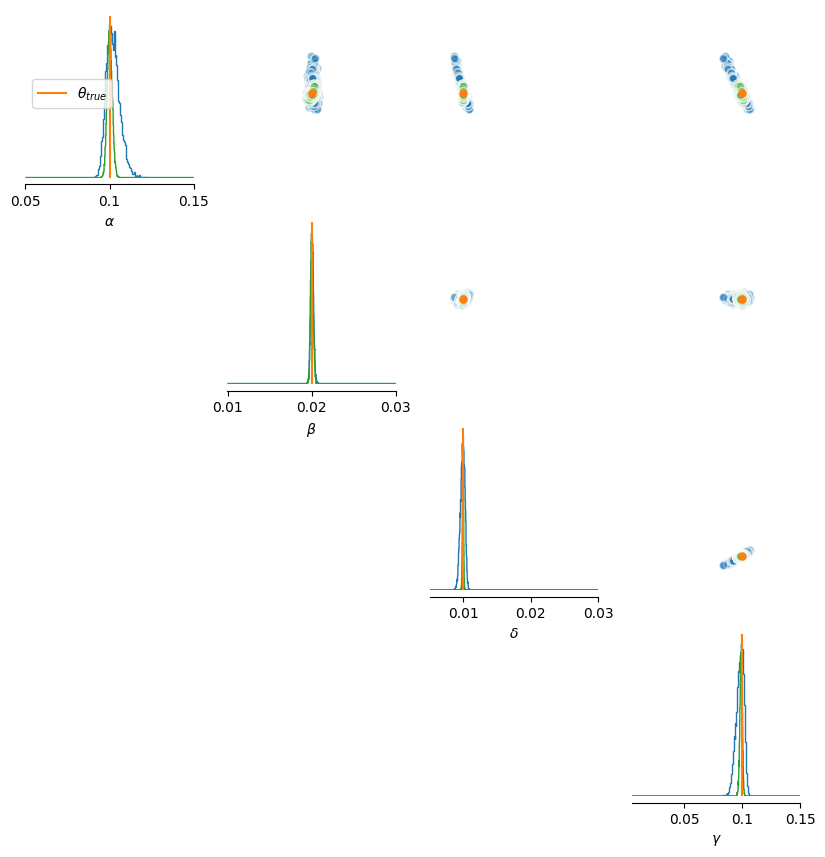

In [37]:
from sbi.analysis import pairplot

param_names = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
prior_limits = [[prior.base_dist.low.numpy()[i], prior.base_dist.high.numpy()[i]] for i in range(len(param_names))] 

fig, ax = pairplot(
    [npe_samples, nle_samples], 
    upper="scatter", 
    limits=prior_limits, 
    labels=param_names,
    points=theta_true.unsqueeze(0),
    fig_kwargs={
        "legend": True, 
        "samples_labels": ["NPE", "NLE"],
        "points_labels": [r"$\theta_{true}$"],
    },
)

### Quantitative Comparison

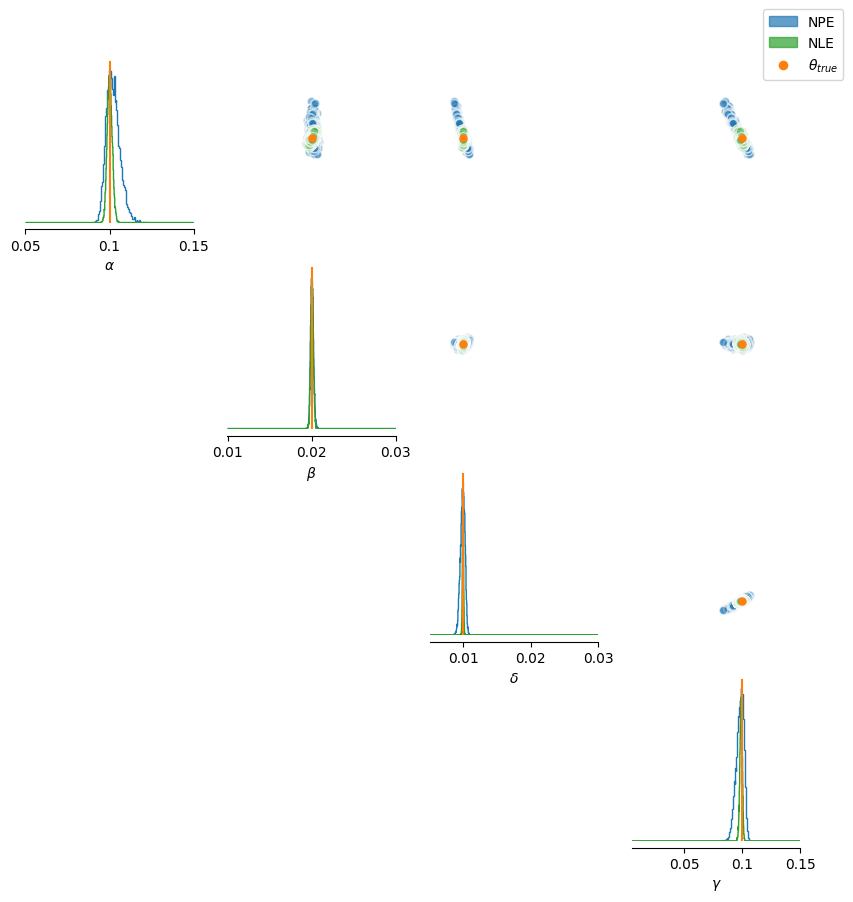

In [38]:
from sbi.analysis import pairplot
from matplotlib.patches import Patch

param_names = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
prior_limits = [[prior.base_dist.low.numpy()[i], prior.base_dist.high.numpy()[i]] for i in range(len(param_names))] 

fig, ax = pairplot(
    [npe_samples, nle_samples], 
    upper="scatter", 
    limits=prior_limits, 
    labels=param_names,
    points=theta_true.unsqueeze(0),
)

# Manual legend (sbi's built-in legend doesn't work well for samples)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend_handles = [
    Patch(facecolor=colors[0], edgecolor=colors[0], alpha=0.7, label='NPE'),
    Patch(facecolor=colors[2], edgecolor=colors[2], alpha=0.7, label='NLE'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=8, label=r'$\theta_{true}$'),
]
fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=10)

In [39]:
# Save samples for comparison in nb_05 (SNPE notebook)
torch.save({
    'npe_samples': npe_samples,
    'nle_samples': nle_samples,
    'theta_true': theta_true,
    'x_o': x_o,
}, 'npe_nle_samples.pt')
print("Saved NPE and NLE samples to 'npe_nle_samples.pt'")

Saved NPE and NLE samples to 'npe_nle_samples.pt'


## 7. Understanding What the Estimators Learn

Both NPE and NLE train a **conditional density estimator** (a normalizing flow). But what they learn is fundamentally different:

| Method | Estimator learns | Condition on | Sample gives |
|--------|-----------------|--------------|--------------|
| **NPE** | $q_\phi(\theta \| x)$ | observation $x$ | **posterior samples** $\theta$ |
| **NLE** | $q_\phi(x \| \theta)$ | parameters $\theta$ | **synthetic data** $x$ |

### The Key Insight

When you **directly sample** from the trained density estimator:

- **NPE estimator** conditioned on $x_o$ → posterior samples $\theta \sim p(\theta|x_o)$
- **NLE estimator** conditioned on $\theta$ → synthetic observations $x \sim p(x|\theta)$

This means with NLE, we can generate synthetic data **without running the simulator**! We just sample from the learned likelihood.

### Sampling from the NPE Estimator

With NPE, we condition the estimator on an observation and get posterior samples:

```python
# NPE: condition on x, sample theta
theta_samples = npe_density_estimator.sample((num_samples,), condition=x_o)
```

This is exactly what `npe_posterior.sample()` does under the hood!

### Exercise: Generate Synthetic Data from the NLE Estimator

Now it's your turn! With NLE, we can generate synthetic summary statistics by conditioning the estimator on parameter values.

**Your task:** 
1. Take the true parameters `theta_true` (or any theta from the posterior)
2. Use `nle_density_estimator.sample()` to generate synthetic summary statistics
3. Compare the synthetic data to the real observation `x_o`

**Hint:** The API is similar to NPE, but you condition on `theta` instead of `x`!

In [40]:
# TODO: Generate synthetic summary statistics from the NLE estimator
# 
# 1. Use nle_density_estimator.sample() with the true parameters
# 2. Generate 100 synthetic observations
# 3. The condition should be theta_true (shape: [1, 4] for batch dimension)

num_synthetic = 100
theta_condition = theta_true.unsqueeze(0)  # Add batch dimension: [4] -> [1, 4]

# YOUR CODE HERE: sample synthetic data from the NLE estimator
x_synthetic_nle = ???

print(f"Synthetic data shape: {x_synthetic_nle.shape}")  # Should be [100, 20]

SyntaxError: invalid syntax (1986369937.py, line 11)

In [ ]:
# %load solutions/solutions_nb_04_synthetic.py

In [ ]:
# Generate ground truth: run the actual simulator with the same theta
# This is what NLE should have learned to emulate!

x_simulated = lotka_volterra_simulator(
    theta_condition.repeat(num_synthetic, 1),  # Repeat theta for num_synthetic runs
    use_autocorrelation=USE_AUTOCORRELATION
)

print(f"Simulated data shape: {x_simulated.shape}")
print(f"NLE synthetic shape:  {x_synthetic_nle.shape}")

### Think First!

**Q: If you sample from the NPE estimator conditioned on x_o, what do you get? And if you sample from the NLE estimator conditioned on some θ?**

<details>
<summary>Click to reveal answer</summary>

- **NPE estimator** `npe_density_estimator.sample(condition=x_o)` → **posterior samples** θ ~ p(θ|x_o)
  - These are samples of parameters that could have produced the observation
  
- **NLE estimator** `nle_density_estimator.sample(condition=θ)` → **synthetic data** x ~ p(x|θ)
  - These are observations that θ would produce (according to the learned likelihood)
  - Should match what the actual simulator would produce for the same θ!

This is fundamental: **NPE learns to invert the simulator, NLE learns to emulate it!**

</details>

## 8. Posterior Predictive Check

A crucial validation step: do simulations from posterior samples produce data similar to the observation?

We'll generate **synthetic data** from both posteriors and compare.

In [41]:
import numpy as np

# Generate synthetic data from posterior samples
n_predictive = 50

# Sample parameters from posteriors
npe_predictive_theta = npe_samples[:n_predictive]
nle_predictive_theta = nle_samples[:n_predictive]

# Simulate summary statistics
npe_predictive_x = lotka_volterra_simulator(npe_predictive_theta, use_autocorrelation=USE_AUTOCORRELATION)
nle_predictive_x = lotka_volterra_simulator(nle_predictive_theta, use_autocorrelation=USE_AUTOCORRELATION)

# Simulate time series for visualization
time = np.arange(0, 200, 0.1)
ts_observed = simulate(theta_true.numpy())
ts_npe = [simulate(npe_predictive_theta[i].numpy()) for i in range(n_predictive)]
ts_nle = [simulate(nle_predictive_theta[i].numpy()) for i in range(n_predictive)]

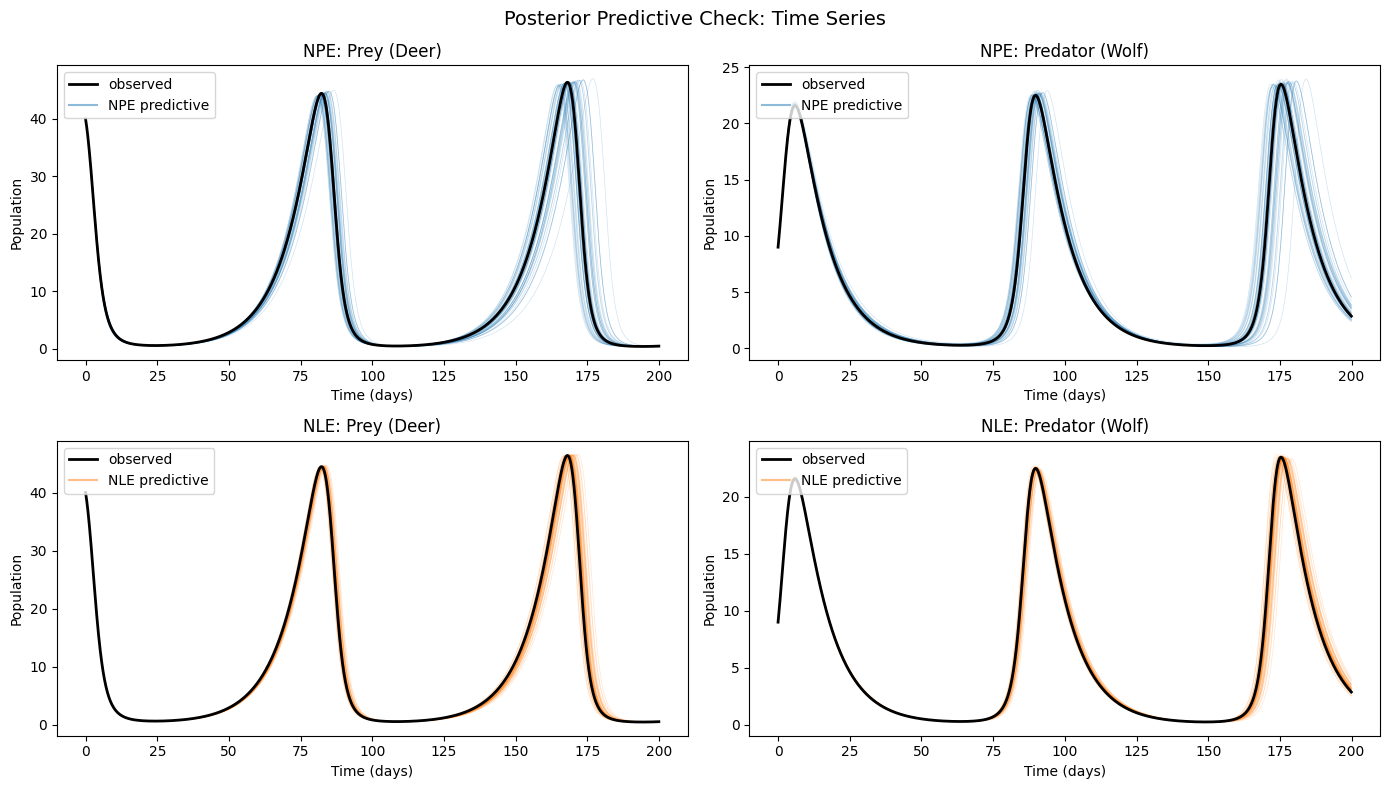

In [42]:
# Posterior predictive: Time series comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# NPE predictive - Prey
ax = axes[0, 0]
for ts in ts_npe:
    ax.plot(time, ts[:, 0], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C0", alpha=0.5, label="NPE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NPE: Prey (Deer)")
ax.legend()

# NPE predictive - Predator
ax = axes[0, 1]
for ts in ts_npe:
    ax.plot(time, ts[:, 1], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C0", alpha=0.5, label="NPE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NPE: Predator (Wolf)")
ax.legend()

# NLE predictive - Prey
ax = axes[1, 0]
for ts in ts_nle:
    ax.plot(time, ts[:, 0], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C1", alpha=0.5, label="NLE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NLE: Prey (Deer)")
ax.legend()

# NLE predictive - Predator
ax = axes[1, 1]
for ts in ts_nle:
    ax.plot(time, ts[:, 1], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2, label="observed")
ax.plot([], [], color="C1", alpha=0.5, label="NLE predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("NLE: Predator (Wolf)")
ax.legend()

plt.suptitle("Posterior Predictive Check: Time Series", fontsize=14)
plt.tight_layout()
plt.show()

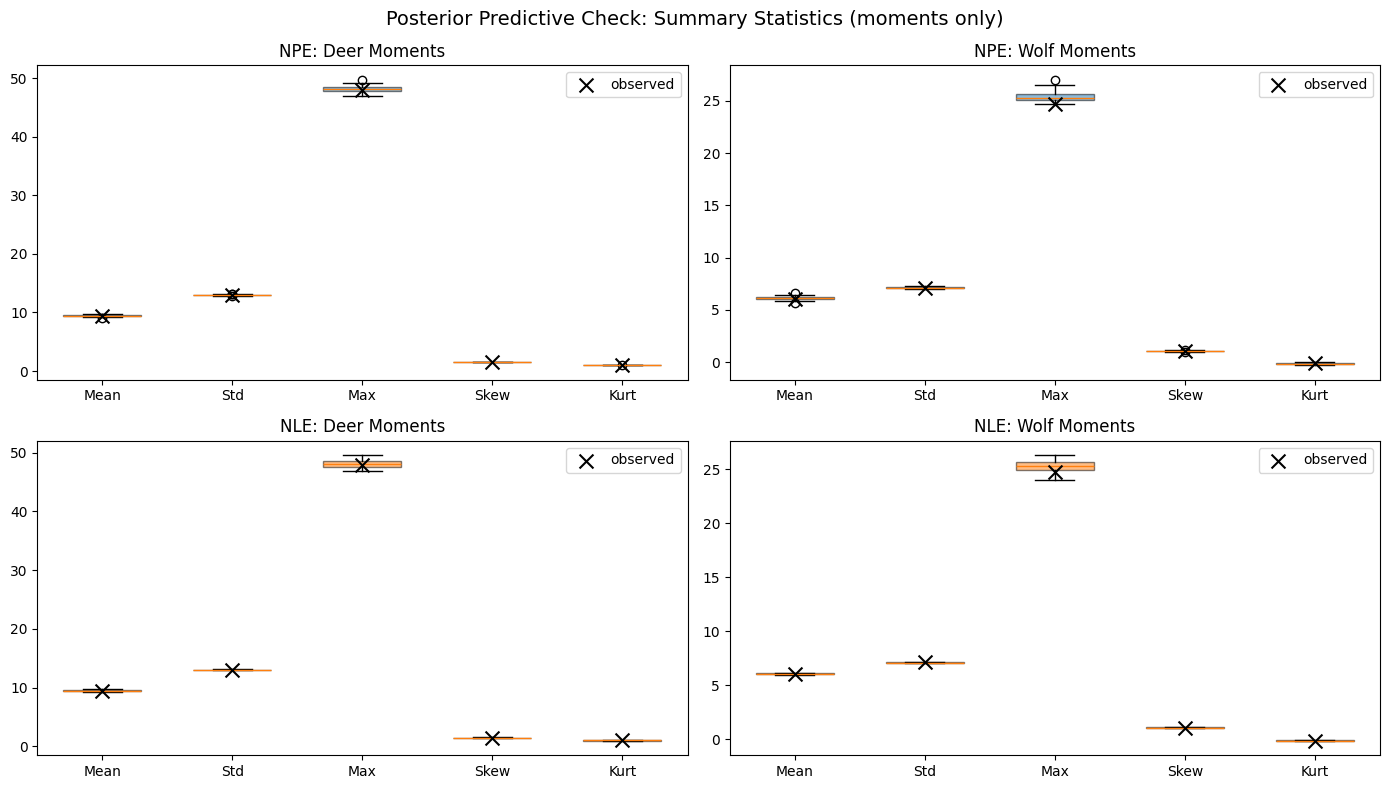

In [43]:
# Posterior predictive: Summary statistics comparison (showing moments only, not autocorrelation)
stat_names = ["Mean", "Std", "Max", "Skew", "Kurt"]
x_obs = x_o.squeeze().numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

positions = np.arange(5)

# NPE - Deer stats (moments only: indices 0-4)
ax = axes[0, 0]
bp = ax.boxplot(npe_predictive_x[:, :5].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[:5], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NPE: Deer Moments")
ax.legend()

# NPE - Wolf stats (moments only: indices 10-14)
ax = axes[0, 1]
bp = ax.boxplot(npe_predictive_x[:, 10:15].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[10:15], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NPE: Wolf Moments")
ax.legend()

# NLE - Deer stats (moments only: indices 0-4)
ax = axes[1, 0]
bp = ax.boxplot(nle_predictive_x[:, :5].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C1')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[:5], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NLE: Deer Moments")
ax.legend()

# NLE - Wolf stats (moments only: indices 10-14)
ax = axes[1, 1]
bp = ax.boxplot(nle_predictive_x[:, 10:15].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C1')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[10:15], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names)
ax.set_title("NLE: Wolf Moments")
ax.legend()

plt.suptitle("Posterior Predictive Check: Summary Statistics (moments only)", fontsize=14)
plt.tight_layout()
plt.show()

## 9. Discussion: Why Does NLE Win Here?

Looking at the results above, **NLE produces tighter, more accurate posteriors** than NPE on this problem. Why?

### The Likelihood Has Simpler Structure

In this Lotka-Volterra example:
- The **posterior is sharply concentrated** in a small region of parameter space
- NPE must learn the mapping $x \to p(\theta|x)$ for the **entire prior space** (amortized)
- With limited simulations (20k), NPE struggles to learn the sharp posterior accurately
- NLE learns the **likelihood** $p(x|\theta)$, which has simpler structure here
- MCMC then concentrates the samples in the right region

### When Does This Happen?

NLE tends to outperform NPE when:
1. **Sharp posteriors**: The posterior is concentrated in a small region
2. **High-dimensional observations**: The likelihood may be easier to model than the posterior
3. **Limited simulation budget**: NPE needs more data to learn accurate posteriors everywhere

### NPE Advantages (When They Apply)
- **Fast inference**: No MCMC needed once trained
- **Fully amortized**: Works instantly for new observations
- **Simple workflow**: Train once, sample many times

### Can We Help NPE?

Yes! **Sequential NPE (SNPE)** addresses this by:
- Training in multiple rounds
- Focusing simulations on the region where the posterior has mass
- No longer fully amortized, but much more simulation-efficient

We'll explore this in the next notebook!

## Summary

| Aspect | NPE | NLE |
|--------|-----|-----|
| **Learns** | $p(\theta|x)$ directly | $p(x|\theta)$ |
| **Inference** | Direct sampling | MCMC |
| **Speed** | Fast (milliseconds) | Slower (seconds-minutes) |
| **Prior flexibility** | Fixed at training | Can change |
| **Amortization** | Full | Partial |
| **Sharp posteriors** | Can struggle | Often better |

### Key Takeaways

1. **NPE is not always the best choice** - NLE can outperform NPE when the likelihood has simpler structure
2. **Same training data** - Both methods use $(\theta, x)$ pairs from prior × simulator
3. **Different trade-offs** - NPE is fast but may need more simulations; NLE is slower but can be more accurate
4. **Always validate** - Posterior predictive checks reveal which method works better for your problem
5. **Sequential methods can help** - SNPE focuses simulations where they matter, helping NPE with sharp posteriors

---

## Next: Sequential Methods

We saw that NPE struggled with this problem due to the sharp posterior. In the **next notebook**, we'll explore **Sequential NPE (SNPE)**:

- Train NPE in multiple rounds
- Each round focuses simulations near the current posterior estimate
- Dramatically improves efficiency for sharp posteriors
- **Exercise**: Implement SNPE and see how it matches NLE's performance with fewer total simulations!

**Continue to Part 3** (slides) for an overview of sequential methods, then hands-on with SNPE.